In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns

from bs_fdbck.util.imports import import_fields_xr_echam

import pandas as pd



from bs_fdbck.constants import path_measurement_data

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud,rn_dic_noresm_cloud, rn_dic_obs_cloud

import datetime

from bs_fdbck.util.BSOA_datamanip import fix_echam_time

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv


In [3]:
from pathlib import Path

from bs_fdbck.util.BSOA_datamanip import ds2df_inc_preprocessing
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
import useful_scit.util.log as log

from bs_fdbck.util.plot.BSOA_plots import make_cool_grid, plot_scatter

log.ger.setLevel(log.log.INFO)
import time
import xarray as xr
import matplotlib.pyplot as plt

In [4]:
xr.set_options(keep_attrs=True) 

In [5]:
calc_seasons = ['ALL_year']#'ALL_year','DRY','WET_mid','WET','WET_34','WET_old','WET_early','WET_late', 'DRY_early','DRY_late', 'ALL_year']

In [6]:
calc_seasons

['ALL_year']

## Time for values

In [7]:
daytime_from = 10
daytime_to = daytime_from + 7

## NorESM

In [8]:
long3 = 360-59.009
(long3 + 180) % 360 - 180

-59.009000000000015

In [9]:
lon_lims = [293.,308.]
lat_lims = [-8.,-1.]

lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K

temperature = 273.15  # K


from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'
sel_years_from_files = ['2012','2014','2015','2018']

In [10]:
case_name = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

case_name1 = 'OsloAero_intBVOC_f09_f09_mg17_full'
case_name2 = 'OsloAero_intBVOC_f09_f09_mg17_ssp245'

In [11]:
cases = [case_name]

### Path input data

In [12]:

path_input_data_noresm = path_extract_latlon_outdata/ case_name

### Filenames

#### Define some strings

In [13]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'

In [14]:
fn1   = path_extract_latlon_outdata/case_name1/f'{case_name1}.h1._{from_time1}-{to_time1}_concat_subs_{str_coordlims}.nc'

fn1_2 = fn1.parent / f'{fn1.stem}_sort.nc'
fn1_3 = fn1.parent / f'{fn1.stem}_sort3.nc'


fn2   = path_extract_latlon_outdata/case_name2 /f'{case_name2}.h1._{from_time2}-{to_time2}_concat_subs_{str_coordlims}.nc'

fn2_2 = fn2.parent / f'{fn2.stem}_sort.nc'
fn2_3 = fn2.parent / f'{fn2.stem}_sort3.nc'

fn_comb                = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
fn_comb_lev1           = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1.nc'
fn_comb_lev1_final     = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_comb_lev1_finaler     = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finaler.nc'
fn_comb_lev1_finaler
fn_comb_lev1_final_csv = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final_wet_season.csv'
fn_final_csv_stem      = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.csv'

In [15]:
fn_comb_lev1_final_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_final_wet_season.csv')

### Station variables

In [16]:
fn1

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_full/OsloAero_intBVOC_f09_f09_mg17_full.h1._2012-01-01-2015-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc')

In [17]:
varl_st = [      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3',
           'N50','N100', 'N150', 'N200', 
                 ]


varl_cl = ['TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP','TGCLDLWP','TGCLDIWP',
           'TOT_CLD_VISTAU_s','TOT_ICLD_VISTAU_s','optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL','ACTNL','TGCLDLWP',
           'FSDSC','FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC','FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

### Read files and compute vertical variables, extract surface layer,  and merge timeseries

In [18]:
fn_comb#.exists()

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc')

In [19]:
if not fn_comb.exists():
    if (not fn1_2.exists()) or (not fn2_2.exists()):
        dfn_final_csv_stemm_dataset(fn1, chunks = {'time':96})#[fn1,fn2])#.sortby('time')
        ds_mod2 = xr.open_dataset(fn2, chunks = {'time':96},engine='netcdf4')

        varl1 = set(ds_mod1.data_vars)

        varl2 = set(ds_mod2.data_vars)


        varl =list(varl1.intersection(varl2))

        ds_mod1 = ds_mod1[varl].sel(time=slice(sel_years_from_files[0],sel_years_from_files[1]))#.sortby('time')

        ds_mod2 = ds_mod2[varl].sel(time=slice(sel_years_from_files[2],sel_years_from_files[3]))#.sortby('time')
        print('HEEEEY')
        if not fn1_2.exists():
            delayed_obj = ds_mod1.to_netcdf(fn1_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
        if not fn2_2.exists():
            delayed_obj = ds_mod2.to_netcdf(fn2_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
    
    if not fn1_3.exists():
            ds_mod1 = xr.open_dataset(fn1_2, chunks = {'time':48},engine='netcdf4')#[fn1,fn2])#.sortby('time')
            ds_mod1 = compute_total_tau(ds_mod1)
            ds_mod1 = ds_mod1.isel(lev = model_lev_i)
            ds_mod1 = ds_mod1.sortby('time')#.sel(time=slice('2012','2014'))
            delayed_obj = ds_mod1.to_netcdf(fn1_3, compute=False)
            print('hey 1')
            with ProgressBar():
                results = delayed_obj.compute()
    if not fn2_3.exists():
            ds_mod2 = xr.open_dataset(fn2_2, chunks = {'time':48},engine='netcdf4')#[fn1,fn2])#.sortby('time')
            ds_mod2 = compute_total_tau(ds_mod2)
            ds_mod2 = ds_mod2.isel(lev = model_lev_i)
            ds_mod2 = ds_mod2.sortby('time')#.sel(time=slice('2012','2014'))
            delayed_obj = ds_mod2.to_netcdf(fn2_3, compute=False)
            print('hey')
            with ProgressBar():
                results = delayed_obj.compute()
    
    
    ds_mod = xr.open_mfdataset([fn1_3,fn2_3], combine='by_coords', concat_dim='time')

    fn_comb.parent.mkdir(exist_ok=True,)

    delayed_obj = ds_mod.to_netcdf(fn_comb, compute = False)
    with ProgressBar():
        results = delayed_obj.compute()

    #ds_mod = xr.concat([ds_mod1[varl].sel(time=slice('2012','2014')), ds_mod2[varl].sel(time=slice('2015','2018'))], dim='time')

### Check: 

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


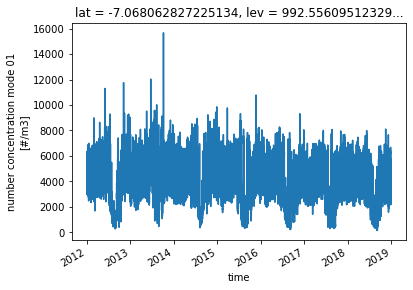

In [20]:
ds_mod = xr.open_dataset(fn_comb,engine='netcdf4', chunks = {'time':48})
(1e-6*ds_mod['NCONC01'].isel(lat=0, lon=0)).plot()

### Broadcast station variables to every gridcell and manipulate units etc

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [21]:
if not fn_comb_lev1_final.exists():
    ds_all = xr.open_dataset(fn_comb,engine='netcdf4').isel(ilev=model_lev_i)
    ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest')#.isel( ilev=model_lev_i)#.load()
    ds_all = ds_all.isel(
             nbnd=0
    ).squeeze()
    ds_all = broadcase_station_data(ds_all, lon = lon_smr, lat = lat_smr)
    ds_all = change_units_and_compute_vars(ds_all, temperature=temperature)


    delayed_obj = ds_all.to_netcdf(fn_comb_lev1_final, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()


### Add station variables: 

In [22]:

varl_tmp =['N50','N100','N150','N200',
           
      #'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      #'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3', 
      ] 

In [23]:
for case_name in [case_name1]:
    varlist = varl_st
    c = CollocateLONLATout(case_name, from_time1, to_time1,
                           True,
                           'hour',
                           history_field='.h1.')
    if c.check_if_load_raw_necessary(varlist ):
        time1 = time.time()
        a = c.make_station_data_merge_monthly(varlist)
        print(a)

        time2 = time.time()
        print('DONE : took {:.3f} s'.format( (time2-time1)))
    else:
        print('UUUPS')

for case_name in [case_name2]:
    varlist = varl_st# list_sized_vars_noresm
    c = CollocateLONLATout(case_name, from_time2, to_time2,
                           False,
                           'hour',
                           history_field='.h1.')
    if c.check_if_load_raw_necessary(varlist ):
        time1 = time.time()
        a = c.make_station_data_merge_monthly(varl_tmp)
        print(a)

        time2 = time.time()
        print('DONE : took {:.3f} s'.format( (time2-time1)))
    else:
        print('UUUPS')

//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/SOA_NA_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/SOA_A1_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/OM_NI_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/OM_AI_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/OM_AC_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_s

In [24]:
dic_ds = dict()
for ca in [case_name1]:
    c = CollocateLONLATout(ca, from_time1, to_time1,
                           False,
                           'hour',
                           history_field='.h1.')
    ds = c.get_collocated_dataset(varl_st)
    if 'location' in ds.coords:
        ds = ds.rename({'location':'station'})
    dic_ds[ca]=ds

2022-10-25 09:58:14,914 useful_scit  INFO     Opening: [//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/SOA_NA_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/SOA_A1_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/OM_NI_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/OM_AI_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/OM_AC_OsloAero_intBVOC_f09_f09_mg17_full_2012-01

//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/SOA_NA_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/SOA_A1_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/OM_NI_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/OM_AI_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/OM_AC_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_s

In [25]:
#dic_ds = dict()
for ca in [case_name2]:
    c = CollocateLONLATout(ca, from_time2, to_time2,
                           False,
                           'hour',
                           history_field='.h1.')
    ds = c.get_collocated_dataset(varl_st)
    if 'location' in ds.coords:
        ds = ds.rename({'location':'station'})
    dic_ds[ca]=ds

2022-10-25 09:58:20,415 useful_scit  INFO     Opening: [//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/SOA_NA_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/SOA_A1_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/OM_NI_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/OM_AI_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/OM_AC_OsloAero_intBVOC_f09_f09

//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/SOA_NA_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/SOA_A1_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/OM_NI_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/OM_AI_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/OM_AC_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc
//p

In [26]:
case1 = case_name1
case2 = case_name2

ds1 = dic_ds[case1]
ds2 = dic_ds[case2]


st_y = from_time1.split('-')[0]
mid_y_t = str(int(to_time1.split('-')[0])-1)
mid_y_f = to_time1.split('-')[0]
end_y = to_time2.split('-')[0]

print(st_y, mid_y_t, mid_y_f, end_y)

_ds1 = ds1.sel(time=slice(st_y, mid_y_t))
_ds2 = ds2.sel(time=slice(mid_y_f, end_y))
ds_comb_station = xr.concat([_ds1, _ds2], dim='time')#.sortby('time')

2012 2014 2015 2019


In [27]:
ds_comb_ATTO = ds_comb_station.sel(station='ATTO').isel(lev=-1)

In [28]:
fn_comb_lev1.exists()

False

In [29]:
from bs_fdbck.util.BSOA_datamanip import broadcast_vars_in_ds_sel

In [30]:
varl_tmp

['N50', 'N100', 'N150', 'N200']

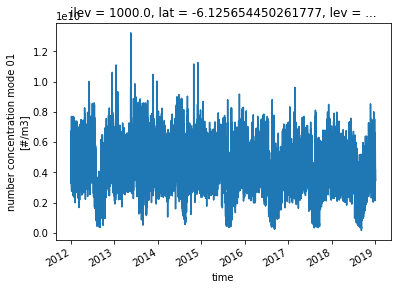

In [61]:

ds_all = xr.open_dataset(fn_comb_lev1_final, chunks = {'lon':1},engine='netcdf4')

ds_all['NCONC01'].isel(lat=1, lon=1).plot()

In [32]:
ds_smll = ds_all[['NCONC01']]

In [33]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_ATTO, varl_tmp, only_already_in_ds= False)

N50
N100
N150
N200


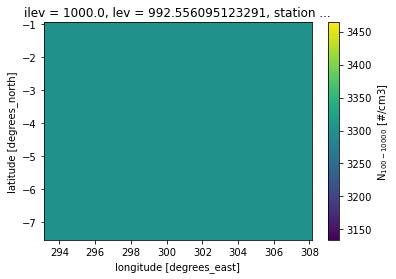

In [34]:
ds_smll['N100'].mean('time').plot()

In [55]:
#ds_smll['COT'].mean('time').plot()

In [35]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

### Finally produce daily median dataframe:

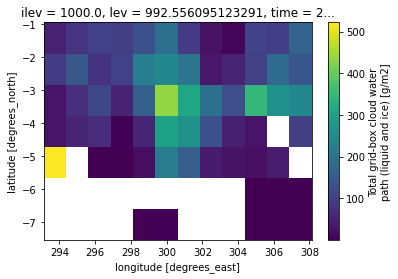

In [62]:
ds_all['TGCLDCWP_incld'].sel(time = '2012-05-30 02:00:00').plot()

In [36]:
dic_ds = dict()
dic_ds[case_name_noresm] =ds_all

In [37]:
from timeit import default_timer as timer



In [38]:
fn_comb_lev1_final_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_final_wet_season.csv')

In [39]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [40]:
season2month

{'WET': [1, 2, 3, 4, 5, 6, 7, 12],
 'WET_old': [1, 2, 3, 4, 5],
 'WET_345': [3, 4, 5],
 'WET_45': [4, 5],
 'WET_34': [3, 4],
 'WET_mid': [2, 3, 4, 5],
 'WET_early': [1, 2, 3, 12],
 'WET_23': [2, 3],
 'FM': [2, 3],
 'DJF': [1, 2, 12],
 'DJ': [1, 12],
 'MJJ': [5, 6, 7],
 'SON': [9, 10, 11],
 'JJA': [6, 7, 8],
 'MAM': [3, 4, 5],
 'WET_late': [4, 5, 6, 7],
 'DRY': [8, 9, 10, 11],
 'DRY_early': [6, 7, 8],
 'ASO': [8, 9, 10],
 'SO': [9, 10],
 'ND': [11, 12],
 'DRY_late': [9, 10, 11, 12],
 'ALL_year': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

In [41]:
for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_noresm_cloud)
    


In [42]:
from dask.diagnostics import ProgressBar

In [43]:
fn_comb_lev1_finaler.exists()

True

In [44]:
if not fn_comb_lev1_finaler.exists():
    with ProgressBar():
        dic_ds[case_name_noresm].to_netcdf(fn_comb_lev1_finaler)

## Shift timezone: 

In [45]:
from datetime import timedelta


dic_ds[case_name_noresm] = xr.open_dataset(fn_comb_lev1_finaler, chunks={'lon':1}, engine='netcdf4')

with ProgressBar():
    dic_ds[case_name_noresm].load()
    
    

for k in dic_ds.keys():
    _ds = dic_ds[k]
    _ds['time'] = _ds['time'].to_pandas().index- timedelta(hours=4)
    dic_ds[k] = _ds

[########################################] | 100% Completed |  1min 50.4s


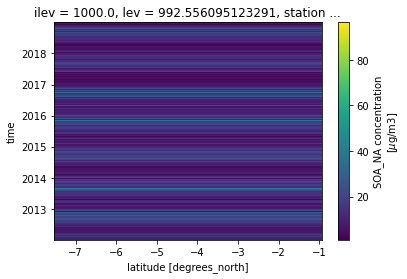

In [46]:
dic_ds[k]['OA'].mean('lon').plot()

In [48]:
for seas in calc_seasons:
    _fn_csv = fn_final_csv_stem.parent / (fn_final_csv_stem.stem + seas+'.csv')
    print(_fn_csv)
    if True:#not _fn_csv.exists():
        start = timer()
        

        dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=season2month[seas], from_hour=daytime_from,
                                kwrgs_mask_clouds = dict(min_reff=1),
                   to_hour=daytime_to,)

        df_mod = dic_df[case_name_noresm]

        df_mod= df_mod.dropna()
        print(_fn_csv)
        df_mod.to_csv(_fn_csv)
        end = timer()
        print(end - start) # Time in seconds, e.g. 5.38091952400282
        print(f'DONE! That took {(end-start)} seconds')    
        print(f'That is  {((end-start)/60)} minuts')
    

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0_lev1_finalALL_year.csv


In [51]:
from bs_fdbck.util.BSOA_datamanip import varl_cl_default, varl_st_default,extract_hours_for_satellite_vars,mask_values_clouds,calculate_daily_median_summer

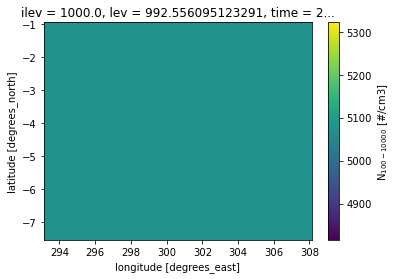

In [47]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['N100'].sel(time = '2012-05-30 02:00:00').plot()

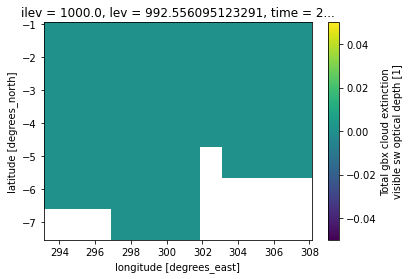

In [53]:
_ds = dic_ds['OsloAero_intBVOC_f09_f09_mg17_fssp245']
_ds['COT'].sel(time = '2012-05-30 02:00:00').plot()

## ECHAM-SALSA

### Names etc

In [53]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'
model_name_echam  ='ECHAM-SALSA'

### Input path:

In [54]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [55]:

cases_echam = [case_name_echam]

### Station variables  and others

In [56]:
varl_st_echam = [
    'mmrtrN500',
    'mmrtrN250',
    'mmrtrN200',
    'mmrtrN100',
    'mmrtrN50',
    'mmrtrN3',
    'SO2_gas',
    'APIN_gas',
    'TBETAOCI_gas',
    'BPIN_gas',
    'LIMON_gas',
    'SABIN_gas',
    'MYRC_gas',
    'CARENE3_gas',
    'ISOP_gas',
    'VBS0_gas',
    'V*BS1_gas',
    'VBS10_gas',
    'ORG_mass',
    'oh_con',
    'tempair',
    'ccn02',
    'ccn10',
]


varl_cl_echam = [
    'airdens',
    'uw',
    'vw',
    'cod',
    'cwp',
    'ceff',
    'ceff_ct',
    #'ceff_ct_incl',
    'lcdnc',
    'lcdnc_ct',
    'clfr',
    'cl_time',
    'aot550nm',
    'up_sw',
    'up_sw_cs',
    'up_sw_noa',
    'up_sw_cs_noa',
    'up_lw',
    'up_lw_cs',
    'up_lw_noa',
    'up_lw_cs_noa',
    'emi_monot_bio',
    'emi_isop_bio',
]

### Define some strings for files

In [57]:

str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

### Filenames: 

In [58]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_wet_season.csv'
fn_final_echam_csv_stem = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

### Open data

In [59]:
fl_open = []

for v in varl_cl_echam+ varl_st_echam:
    fn = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_{v}_concat_subs_{str_coordlims}.nc'
    #print(fn)
    if fn.exists():
        fl_open.append(fn)

In [60]:
len(fl_open)

29

In [61]:
fl_open

[PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_airdens_concat_subs_293.0-308.0_-8.0--1.0.nc'),
 PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_uw_concat_subs_293.0-308.0_-8.0--1.0.nc'),
 PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_vw_concat_subs_293.0-308.0_-8.0--1.0.nc'),
 PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_cod_concat_subs_293.0-308.0_-8.0--1.0.nc'),
 PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-0

### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [62]:
if not fn_final_echam.exists():
    ds_all = xr.open_mfdataset(fl_open, decode_cf = False)
    #ds_iso = xr.open_dataset(fl_open[21])
    #ds = xr.merge([ds_iso,ds])
    ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)


    

    #ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)
    ds_all = extract_2D_cloud_time_echam(ds_all) 



    #ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest').isel( lev=model_lev_i)#.load()
    ds_all = ds_all.squeeze()
    ds_all=ds_all.drop(['hyai','hybi','hyam','hybm']).squeeze()
    ds_all = ds_all.isel( lev=model_lev_i)
    


    ds_all = broadcase_station_data(ds_all, varl_st=varl_st_echam, lon = lon_smr, lat = lat_smr)
    

    ds_all = change_units_and_compute_vars_echam(ds_all)

    delayed_obj = ds_all.to_netcdf(fn_final_echam, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

In [64]:
print('hey')

hey


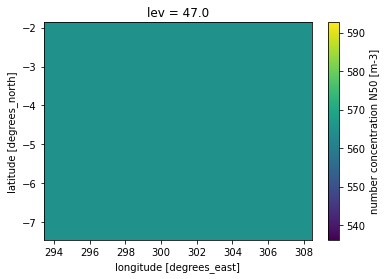

In [65]:
ds_all = xr.open_dataset(fn_final_echam,engine='netcdf4')
ds_all['N50'].mean('time').plot()#.isel(lat=0, time=0).plot()#.shape#.plot()

In [46]:
ds_all['cwp_incld'].isel(lat=1, lon=1).plot()

KeyError: 'cwp_incld'

In [66]:
ds_all['tempair_ct']

<xarray.DataArray 'tempair_ct' (time: 61368, lat: 3, lon: 8)>
[1472832 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -2.798 -4.663 -6.528
    lev      float64 ...
  * lon      (lon) float64 294.4 296.2 298.1 300.0 301.9 303.8 305.6 307.5
  * time     (time) datetime64[ns] 2012-01-01T00:52:30 ... 2018-12-31T23:52:30
Attributes:
    long_name:    air temperature
    units:        K
    description:  air_temperature

### Fix time for echam

In [68]:
ds_all['time'] = ds_all['time'].to_dataframe()['time'].apply(fix_echam_time).values

In [69]:
ds_all['cwp']

<xarray.DataArray 'cwp' (time: 61368, lat: 3, lon: 8)>
[1472832 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -2.798 -4.663 -6.528
    lev      float64 47.0
  * lon      (lon) float64 294.4 296.2 298.1 300.0 301.9 303.8 305.6 307.5
  * time     (time) datetime64[ns] 2012-01-01 ... 2018-12-31T23:00:00
Attributes:
    long_name:    cloud liquid water path
    units:        k m $^{-2}$
    description:  cloud liquid water path

### Finally produce daily median dataframe:

In [70]:
dic_ds = dict()
dic_ds[case_name] =ds_all

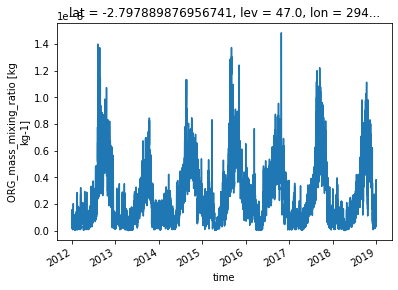

In [71]:
ds_all['ORG_mass'].isel(lat=0,lon=0).plot()

In [72]:
fn_final_echam_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0_wet_season.csv')

(array([1.375213e+06, 1.215000e+04, 2.812500e+04, 2.663300e+04,
        1.977300e+04, 8.588000e+03, 1.915000e+03, 2.870000e+02,
        9.900000e+01, 4.900000e+01]),
 array([ 0.       ,  3.7016654,  7.403331 , 11.104997 , 14.806662 ,
        18.508327 , 22.209993 , 25.91166  , 29.613323 , 33.31499  ,
        37.016655 ], dtype=float32),
 <BarContainer object of 10 artists>)

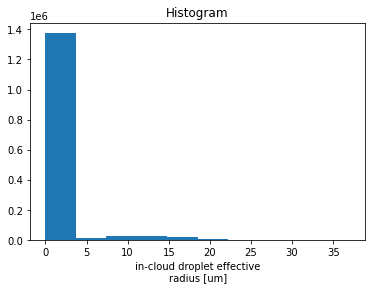

In [73]:
ds_all['ceff_um'].plot()

In [74]:
import numpy as np

(array([13209., 24301., 27070., 40948., 58481., 71660., 75368., 74456.,
        75064., 81379., 84648., 46474., 15310.,  8995.,  7069.,  5856.,
         5333.,  4815.,  4099.]),
 array([ 0.        ,  1.57894737,  3.15789474,  4.73684211,  6.31578947,
         7.89473684,  9.47368421, 11.05263158, 12.63157895, 14.21052632,
        15.78947368, 17.36842105, 18.94736842, 20.52631579, 22.10526316,
        23.68421053, 25.26315789, 26.84210526, 28.42105263, 30.        ]),
 <BarContainer object of 19 artists>)

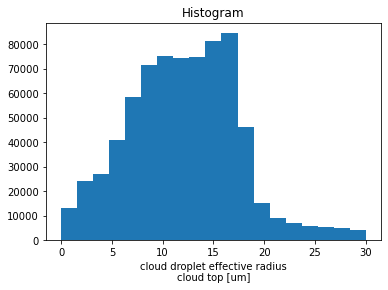

In [75]:
ds_all['ceff_ct_incld'].plot(bins = np.linspace(0,30,20))

(array([34691., 50322., 48041., 54745., 71496., 83141., 83601., 80670.,
        78559., 77806., 75384., 33808.,  8932.,  5327.,  3976.,  3243.,
         2897.,  2614.,  2278.]),
 array([ 0.        ,  1.57894737,  3.15789474,  4.73684211,  6.31578947,
         7.89473684,  9.47368421, 11.05263158, 12.63157895, 14.21052632,
        15.78947368, 17.36842105, 18.94736842, 20.52631579, 22.10526316,
        23.68421053, 25.26315789, 26.84210526, 28.42105263, 30.        ]),
 <BarContainer object of 19 artists>)

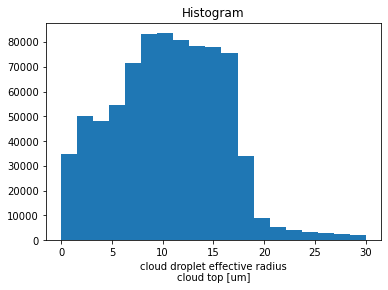

In [76]:
ds_all['ceff_ct'].plot(bins = np.linspace(0,30,20))

(array([352274., 165254.,  88824.,  51290.,  30388.,  19212.,  12261.,
          8009.,   5174.,   3538.,   2458.,   1840.,   1406.,   1114.,
           862.,    731.,    568.,    513.,    396.]),
 array([   0.        ,   52.63157895,  105.26315789,  157.89473684,
         210.52631579,  263.15789474,  315.78947368,  368.42105263,
         421.05263158,  473.68421053,  526.31578947,  578.94736842,
         631.57894737,  684.21052632,  736.84210526,  789.47368421,
         842.10526316,  894.73684211,  947.36842105, 1000.        ]),
 <BarContainer object of 19 artists>)

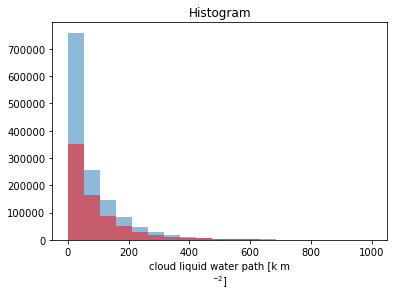

In [77]:
ds_all['cwp'].plot(bins=np.linspace(0,1000,20),alpha=.5, )

ds_all['cwp_incld'].plot(bins=np.linspace(0,1000,20), alpha=.5, color='r')

## Shift timezone: 

In [78]:
from datetime import timedelta

In [79]:
for k in dic_ds.keys():
    _ds = dic_ds[k]
    _ds['time'] = _ds['time'].to_pandas().index- timedelta(hours=4)

## Save for different seasons: 


In [80]:
season2month

{'WET': [1, 2, 3, 4, 5, 6, 7, 12],
 'WET_old': [1, 2, 3, 4, 5],
 'WET_345': [3, 4, 5],
 'WET_45': [4, 5],
 'WET_34': [3, 4],
 'WET_mid': [2, 3, 4, 5],
 'WET_early': [1, 2, 3, 12],
 'WET_23': [2, 3],
 'FM': [2, 3],
 'DJF': [1, 2, 12],
 'DJ': [1, 12],
 'MJJ': [5, 6, 7],
 'SON': [9, 10, 11],
 'JJA': [6, 7, 8],
 'MAM': [3, 4, 5],
 'WET_late': [4, 5, 6, 7],
 'DRY': [8, 9, 10, 11],
 'DRY_early': [6, 7, 8],
 'ASO': [8, 9, 10],
 'SO': [9, 10],
 'ND': [11, 12],
 'DRY_late': [9, 10, 11, 12],
 'ALL_year': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

In [81]:
#calc_seasons = ['WET','DRY', 'WET_mid','WET_early','WET_late', 'DRY_early','DRY_late']

for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_echam_cloud)

In [83]:
dic_ds[key]['tempair_ct']

<xarray.DataArray 'tempair_ct' (time: 61368, lat: 3, lon: 8)>
[1472832 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -2.798 -4.663 -6.528
    lev      float64 47.0
  * lon      (lon) float64 294.4 296.2 298.1 300.0 301.9 303.8 305.6 307.5
  * time     (time) datetime64[ns] 2011-12-31T20:00:00 ... 2018-12-31T19:00:00
Attributes:
    long_name:    air temperature
    units:        K
    description:  air_temperature

In [85]:
for seas in calc_seasons:
    _fn_csv = fn_final_echam_csv_stem.parent / (fn_final_echam_csv_stem.stem + seas+'.csv')
    print(_fn_csv)
    if True:#not _fn_csv.exists():
        #for key in dic_ds.keys():
    
        dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=season2month[seas],mask_cloud_values =True,
                                kwrgs_mask_clouds = dict(min_reff=1))

        df_mod = dic_df[case_name_echam]
        #with ProgressBar():
        df_mod = df_mod.dropna()    
        df_mod.to_csv(_fn_csv)

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv
{'min_reff': 1}
Masking with 5<COT<50!
Masking with 50<CWP!
Masking with r_eff>1!
Masking with temp>-15!


if not fn_final_echam_csv.exists():
    for key in dic_ds:
        dic_ds[key] = dic_ds[key].rename(rn_dic_echam_cloud)
    
    dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=season2month['WET'])

    df_mod = dic_df[case_name]
    df_mod.to_csv(fn_final_echam_csv)

_df = pd.read_csv(fn_comb_lev1_final_csv, index_col=0)#[_df['isSummer'].notnull()]

_df = _df[_df['isSummer'].notnull()]

pd.to_datetime(_df.index).month.unique()

fn_comb_lev1_final_csv

fn_final_echam_csv

## EXTRA

In [ ]:

ds_all = xr.open_dataset(fn_comb_lev1_final)

ds_all['NCONC01'].isel(lat=1, lon=1).plot()

In [ ]:
ds_all['OA'].attrs['units'] = 'ug'

In [ ]:
ds_all.plot.scatter(x='OA',y='CLDFREE', alpha=0.1)

In [ ]:
ds_all['TOT_CLD_VISTAU_s_incld']

In [ ]:
ds_all['month'] = ds_all['time.month']

In [ ]:
ma = ((ds_all['TGCLDCWP_incld']<200 ) & (ds_all['TGCLDCWP_incld']>150 ) )& (ds_all['time.hour']<16 ) & (ds_all['time.hour']>10 ) 
ma = ma & ( (ds_all['month']>=6 ) &(ds_all['month']<=8 ))

In [ ]:
ds_all.where(ma).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_m = ds_all#.where(ma)

In [ ]:
ds_m.isel(lat=0, lon = 0).groupby(ds_m['time.hour']).mean()['FLNTCDRF'].plot()

In [ ]:
ds_all.where(ma).plot.scatter(x='OA',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_all['hour'] = ds_all['time.hour']
ds_all['month'] = ds_all['time.month']

In [ ]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP_incld',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

In [ ]:
ds_all.where((ma&(ds_all['month']==8))).plot.scatter(x='hour',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

In [ ]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP_incld',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

In [ ]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

In [ ]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP',y='TOT_CLD_VISTAU_s', alpha=0.1)
plt.ylim([0,100])

In [ ]:
ds_all.where(ma).plot.scatter(x='CLDTOT',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_all.where((ds_all['time.hour']<15) & (ds_all['time.hour']>10) ).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_all.where((ds_all['time.hour']<15) & (ds_all['time.hour']>10) ).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_all.where(ma).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_all.where(ma).plot.scatter(x='CLDTOT',y='CLDFREE', alpha=0.1,)

In [ ]:
ds_all['CLDFREE'].sel(lat=lat_smr, lon  = lon_smr, method = 'nearest').plot.hist()

In [ ]:
ds_all['CLDTOT'].sel(lat=lat_smr, lon  = lon_smr, method = 'nearest').plot.hist()

In [ ]:
ds_all['TGCLDCWP_incld'].where(ds_all['CLDFREE']<.99).mean('time').plot()

In [ ]:
ds_all['ACTNL_incld'].where(ds_all['CLDFREE']<.99).mean('time').plot()

In [ ]:
ds_all['TGCLDCWP_incld'].mean('time').plot()

In [ ]:
ds_all['TGCLDCWP'].mean('time').plot()

In [ ]:
ds_all['TOT_CLD_VISTAU_s'].mean('time').plot()

In [ ]:
ds_all['TOT_CLD_VISTAU_s_incld'].where(ma).mean('time').plot()

In [ ]:
ds_all['TOT_CLD_VISTAU_s_incld'].where(ma).median('time').plot()